In [54]:
import jax
import jax.numpy as jnp
from jax import random, grad

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

In [2]:
DATASET_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv"
df = pd.read_csv(DATASET_URL, sep=";")
df.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [83]:
def model(X, y=None):
    theta0 = numpyro.sample("theta0", dist.Normal(0.0, 1.0)).reshape(-1, 1)
    theta1 = numpyro.sample("theta1", dist.Normal(0.0, 1.0)).reshape(-1, 1)
    Theta = jnp.concatenate((theta0, theta1), axis=-1)
    mu = jnp.matmul(X, Theta.T).reshape(-1)
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))
    numpyro.sample("obs", dist.Normal(mu, sigma), obs=y)

In [84]:
X = df[["Marriage", "MedianAgeMarriage"]].to_numpy()
y = df["Divorce"].to_numpy()
print(X.shape, y.shape)

(50, 2) (50,)


In [85]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4)
mcmc.run(rng_key_, X, y)
mcmc.print_summary()

/anaconda3/lib/python3.7/site-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 4394.99it/s, 23 steps of size 1.54e-01. acc. prob=0.95]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     sigma      1.80      0.18      1.78      1.48      2.07   1840.08      1.00
    theta0      0.26      0.06      0.26      0.15      0.34   1163.65      1.01
    theta1      0.17      0.05      0.17      0.10      0.25   1198.57      1.01

Number of divergences: 0


In [86]:
posterior = mcmc.get_samples()
theta0 = posterior["theta0"].reshape(-1, 1)
theta1 = posterior["theta1"].reshape(-1, 1)
theta = jnp.concatenate((theta0, theta1), axis=-1)
sigma = posterior["sigma"].reshape(-1, 1)
print(theta.shape, sigma.shape)

(4000, 2) (4000, 1)


In [116]:
def project_analytic(theta, sigma, X, num_params=1):
    """Primary projection method for a Bayesian linear regression.
    
    The projection function for this method is taken from Equation (6) in
    @Piirnonen2016, and the projection of the linear model variance is from
    Equation (7). 
    
    To do:
        * Fix `vmap` axes bug for sigma_perp projection
    
    Args:
        theta (ndarray): MCMC samples of the learned full parameters
        sigma (ndarray): MCMC samples of the learned regression noise
        X (ndarray): Full data space
        num_params (int): The size of the restricted parameter space

    Returns:
        ndarray: Restricted rojection of the parameter parameters
    """

    def _proj_theta(theta):
        """Analytic projection of the full parameters.
        
        Args:
            theta (ndarray): The full parameter space
            X (ndarray): The full data set
            X_perp (ndarray): The restricted data set
            
        Returns:
            ndarray: The restricted projections of the parameters
        """

        f = X @ theta.T
        theta_perp = jnp.linalg.inv(X_perp.T @ X_perp) @ X_perp.T @ f
        return theta_perp

    def _proj_sigma(theta, theta_perp):
        """Analytic projection of the full noise parameter.
        
        Args:
            theta (ndarray): The full parameter space
            theta_perp (ndarray): The restricted parameter space
            
        Returns:
            ndarray: The restricted projections of the model noise
        """

        f = X @ theta.T
        f_perp = X_perp @ theta_perp.T
        sigma_perp = jnp.sqrt(sigma ** 2 + 1 / n * (f - f_perp).T @ (f - f_perp))
        return sigma_perp

    # extract the number of data observations
    n = X.shape[0]
    # build restricted data space
    X_perp = X[:, :p]
    # perform projections
    theta_perp = jax.vmap(_proj_theta, in_axes=0, out_axes=0)(theta)
    sigma_perp = jax.vmap(_proj_sigma, in_axes=(0, 0), out_axes=0)(
        theta, theta_perp
    ).mean(axis=0) # TODO: fix vmap for sigma projection
    return theta_perp, sigma_perp

In [117]:
theta_perp, sigma_perp = project_analytic(theta, sigma, X)
print(theta_perp.shape, sigma_perp.shape)

(4000, 1) (4000, 1)


In [118]:
datadict = {
    "theta_0_perp": theta_perp,
    "theta_0": theta0,
    "theta_1": theta1,
    "sigma_perp": sigma_perp,
    "sigma": sigma,
}
dataset = az.convert_to_inference_data(datadict)
dataset

/anaconda3/lib/python3.7/site-packages/arviz/data/base.py:174: UserWarning: More chains (4000) than draws (1). Passed array should have shape (chains, draws, *shape)
  UserWarning,


Inference data with groups:
	> posterior

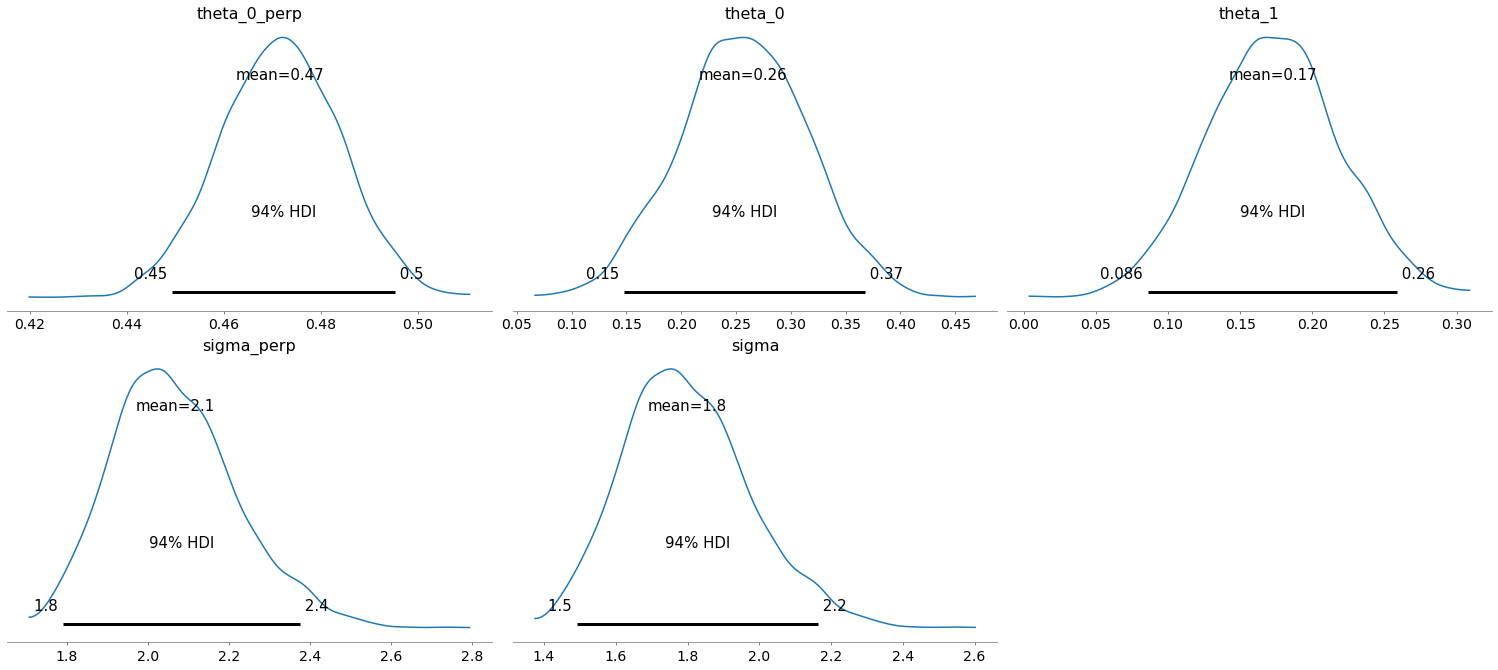

In [119]:
az.plot_posterior(dataset)
plt.show()

In [121]:
def get_proj_dist(theta, theta_perp, X, X_perp):
    """Compute the distance from the projection to full parameters.
    
    Compute the Kullback-Leibler distance between the full
    parameters and the projected parameters given some full and 
    restricted data sets.
    """
    
    def _kl(theta, theta_perp):
        f = X @ theta.T
        f_perp = X_perp @ theta_perp.T
        return (f - f_perp).T @ (f - f_perp)

    return jax.vmap(_kl, in_axes=(0,0), out_axes=0)(theta, theta_perp)

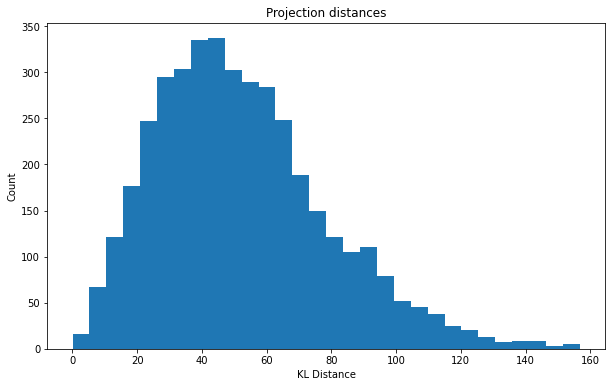

In [129]:
X_perp = X[:, :1]
proj_dists = get_proj_dist(theta, theta_perp, X, X_perp)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.hist(proj_dists, bins=30)
plt.title("Projection distances")
plt.xlabel("KL Distance")
plt.ylabel("Count")
plt.show()